# Agenda
In this notebook we will explore the K-Means algorithm. We will get some basic intuition, we will examine our sample data set, and then we will get acquainted with the scikitlearn implimentation.
1. Introduction to The K-Means Algorithm
2. Visual Inspection Of Our Sample Data
3. Explore The Scikit-Learn Implimentation
4. Colors and Matplotlib Scatter Plots
5. Hyperparameter tuning

# 1. Introduction To The K-Means Algorithm

## 1.1. K-Means Overview
**Unsupervised Learning** is a subfield of machine learning that focuses on recognizing and discovering patterns within a given data set without being explicitly given any information about the pattern or underlying relationshpis.

A subfield of unsupervised learning is **Cluster Analysis**. Cluster analysis is concerned with categorizing data points into groups based on similarity. In other words, if there are two clusters of data within our universe, one would expect there to be a measurable difference between the average point of cluster A compared to cluster B.

The **K-Means algorithm** is a specific clustering algorithm which this workbook focuses on. The basic premise of the model is that a user will specify a number of clusters and the algorithm divide our data the best way possible. The algorithm gets its name because the user specifies K cluster in which to allocate data point and the algorithm fits K centroids to the data to establish a central point for the cluster. (more on this in 3.3).

## 1.2. History of K-Means

The term "k-means" was first used by James MacQueen in 1967, though the idea goes back to Hugo Steinhaus in 1956. The standard algorithm was first proposed by Stuart Lloyd of Bell Labs in 1957 although it was not published as a journal article until 1982. In 1965, Edward W. Forgy published essentially the same method, which is why it is sometimes referred to as the Lloyd–Forgy algorithm.

https://en.wikipedia.org/wiki/K-means_clustering#History

## 1.3. The Basic Algorithm

The **centroid**, or central point of the cluster, is such that it provides the minimal aggregate Euclidian distance between it and the rest of the points in the cluster. Each cluster will have a centroid. The centroid being an "average" representaion of the poins within the cluster is where the term K-means comes from. K clusters means K centroids (ie K means).

Finding the centroid is reduced to an optimization problem which can be solved by numerical approximation. In the case of K-Means, we will setup a recursive convergent function and itertate through the values of the function until we approach that convergent point within some acceptable level of error.

The algorithm does not guarantee convergence to the global optimum. The result may depend on the initial clusters. As the algorithm is usually fast, it is common to run it multiple times with different starting conditions.

To summarize, the algorithm breaks down into the following components: 
- An initialization step - We set the initial values of of centroids. This is the starting point from which we will iterate and optimize.
- A measure of distance - The centroids and cluster membership are established based on a measure of distance. This is a quantitative explanation of how goo a centroid fits the cluster members
- A convergent / optimizable function - In order to find the optimal point, one must exist. There are many numerical methods for finding an optimal point and there are many types of functions which express the optimal point. Typically, in the case of K-Means, our optimizable function is not known ahead of time and we will be using a "search algorithm" to iteratively (and sometimes recursively) search along a convergent path for an optimal point. This is why we will see a convergent function listed as a prerequisite.
- A numerical method to find the convergent point


The basic K-Means algorithm is as follows:
1. Initialization - randomly select a group of K centroids for our K clusters
2. Loop through the data points and assign them to a cluster
    - The assignment is based on our measure of distance $D_i$ between the data point $x_i$ and the centroid $c_j$
    - Mathematically this is represented as: $D_j := arg min \lVert x_i - c_j \lVert$
    - Here we are using the L2 Norm as the measure of Euclidian Distance
    - We assigne $x_i$ to the cluster $k_i$ based on the distance $D_j$ from the cluster's centroid $c_j$
3. Loop through the clusters and recompute centroid
    - The calculation is based on the mean of the data points within the cluster
    - Mathematically this is represented as: $c_j := \sum_i{x_i} $
4. If none of the cluster assignments have changed we have converged and the algorithm is finished
5. If we have not converged, go back to step 2


We can see an example of the algorithm at work here:

<img src='k-means_convergence.gif' style='display: block;max-width: 100%;height: auto;margin: auto;float: none!important;width:300px'>

A nice youtube video can he found [here](https://youtu.be/_aWzGGNrcic)

## 1.4. Additional thoughts
- Are clusters uniformally distributed? No
- Shortcomings: micky mouse diagram above: head and two ears... why are we having problems? Outliers throwing off fit... human to reclassify?
- euclidian distance is huge importance. Nonlinear transformations will affect our results. Example: normalizing vs squaring a number

## 1.5. Variations Of The Algorithm
As mentioned earlier, the algorithm breaks down into several components which can be swapped out. There are a number of variations to the algorithm which consist of changing one or more of these parts. For example K-medians uses the median rather than the mean as the measure of distance. [Wikipedia](https://en.wikipedia.org/wiki/K-means_clustering#Variations) has a list of some of the alternatives.



# 2. Examine Our Sample Data
We will be working with a set of stock data from NASDAQ from an arbitrary day. We will be looking to see if there are any clusters among the data related to the open prices

## 2.1. Load and configure libraries

In [1]:
# Import libraries to manipulate data
import pandas
import numpy 
import scipy

# Import library for visualizing data
import matplotlib
import matplotlib.pyplot as pyplot

# Import the progress so we can display progress for long running calculations in real time
import progressbar

# Import webcolors to help us identify the colors being automatically assigned to our graphs
import webcolors

In [2]:
# Tell pandas to supress scientific notation and display decimals with 5 places
pandas.set_option('display.float_format', lambda x: '%.5f' % x)

# We can undo this operation with:
#pandas.reset_option('display.float_format')

# 2.2. Load Data

Load our OHCLV data for the exchange into a dataframe

In [3]:
# Import the utilities module we wrote
import importlib.util
spec = importlib.util.spec_from_file_location("utilities", "../Utilities/utilities.py")
utilities = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utilities)

# Read the file into a dataframe
file_path = "../nasdaq_2019.csv"
converter_mapping = {
    "date": utilities.convert_date_string_to_date
}
pandas_dataframe = pandas.read_csv(file_path, converters=converter_mapping)

## 2.3 Transform our data
We want to add some features to our data based on the open price and we want to select a subset of the data that representes a particular date

In [4]:
# Add some additional columns to the data
pandas_dataframe["d_open"] = 0
pandas_dataframe["d2_open"] = 0
pandas_dataframe["ma_open"] = 0
pandas_dataframe["prev_open"] = 0

tickers = numpy.sort(pandas_dataframe["ticker"].unique())

# Create a progress bar to keep us updates while the numbers crunch
num_ops = len(tickers)
progress_bar_widgets = [
    progressbar.Bar('=', '[', ']'), 
    ' ', 
    progressbar.FormatLabel('Processed: %(value)d / {0} ops'.format(num_ops)),
    ' ', 
    progressbar.ETA()
]
bar = progressbar.ProgressBar(maxval=num_ops, widgets=progress_bar_widgets)
bar.start()
count = 0

for ticker in tickers:
    ticker_df = pandas_dataframe[pandas_dataframe["ticker"] == ticker]
    d_open = ticker_df["open"].diff()
    pandas_dataframe.loc[ticker_df.index, "d_open"] = d_open
    pandas_dataframe.loc[ticker_df.index, "d2_open"] = d_open.diff()
    pandas_dataframe.loc[ticker_df.index, "ma_open"] = ticker_df["open"].rolling(5).mean()
    pandas_dataframe.loc[ticker_df.index, "prev_open"] = ticker_df["open"].shift(1)
    count += 1
    bar.update(count)

In [5]:
# Get a subset of our data for a particular date
df_07_11_2019 = pandas_dataframe[pandas_dataframe["date"] == '2019-07-11']
df_07_11_2019.head()

,ticker,interval,date,open,high,low,close,volume,d_open,d2_open,ma_open,prev_open
22498,AABA,D,2019-07-11,69.38000,69.72000,68.90000,69.28000,2534300,-0.61000,-1.70000,69.59400,69.99000
22499,AAL,D,2019-07-11,33.06000,33.30000,32.82000,33.03000,6842800,0.13000,-0.40000,32.58400,32.93000
22500,AAME,D,2019-07-11,2.34500,2.34500,2.29000,2.29000,800,0.00500,0.10500,2.37500,2.34000
22501,AAOI,D,2019-07-11,10.45000,10.45000,9.87000,9.90000,610700,-0.39000,-1.12000,10.20000,10.84000
22502,AAON,D,2019-07-11,50.98000,51.14000,49.68000,49.85000,83600,0.68000,0.11000,49.84800,50.30000


## 2.4. Visual inspection
We first visually inspect our data to gain some intuition about the possible underlying clusters. Some data does not lend iteslf well to cluster analysis so we will need to check that our features will provide useful information to the clustering algorithm.

### 2.4.1. Look at the distributions of our features

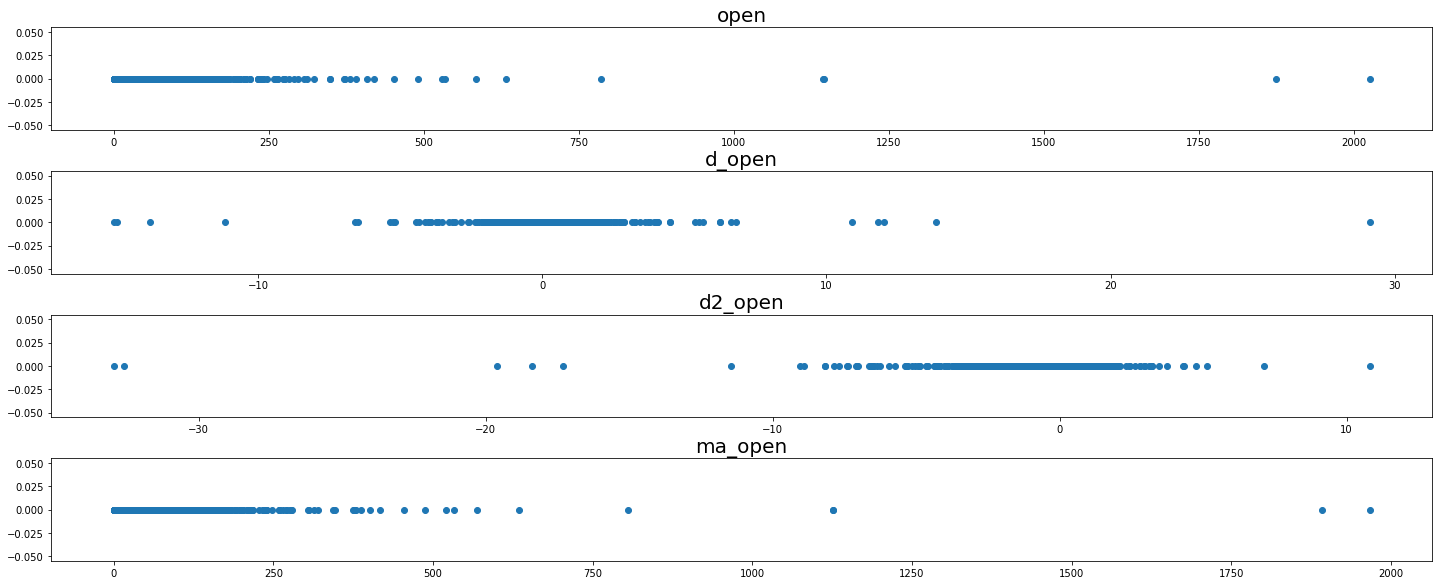

In [6]:
fig, (ax0, ax1, ax2, ax3) = pyplot.subplots(figsize=(20, 8), nrows=4, ncols=1)
fig.tight_layout(h_pad=2)

zeros = [0 for o in df_07_11_2019["open"]]
ax0.set_title("open", fontsize=20);
ax0.scatter(df_07_11_2019["open"], zeros)
ax1.set_title("d_open", fontsize=20);
ax1.scatter(df_07_11_2019["d_open"], zeros)
ax2.set_title("d2_open", fontsize=20);
ax2.scatter(df_07_11_2019["d2_open"], zeros)
ax3.set_title("ma_open", fontsize=20);
ax3.scatter(df_07_11_2019["ma_open"], zeros);

## 2.4.2. Look at the joint distributions

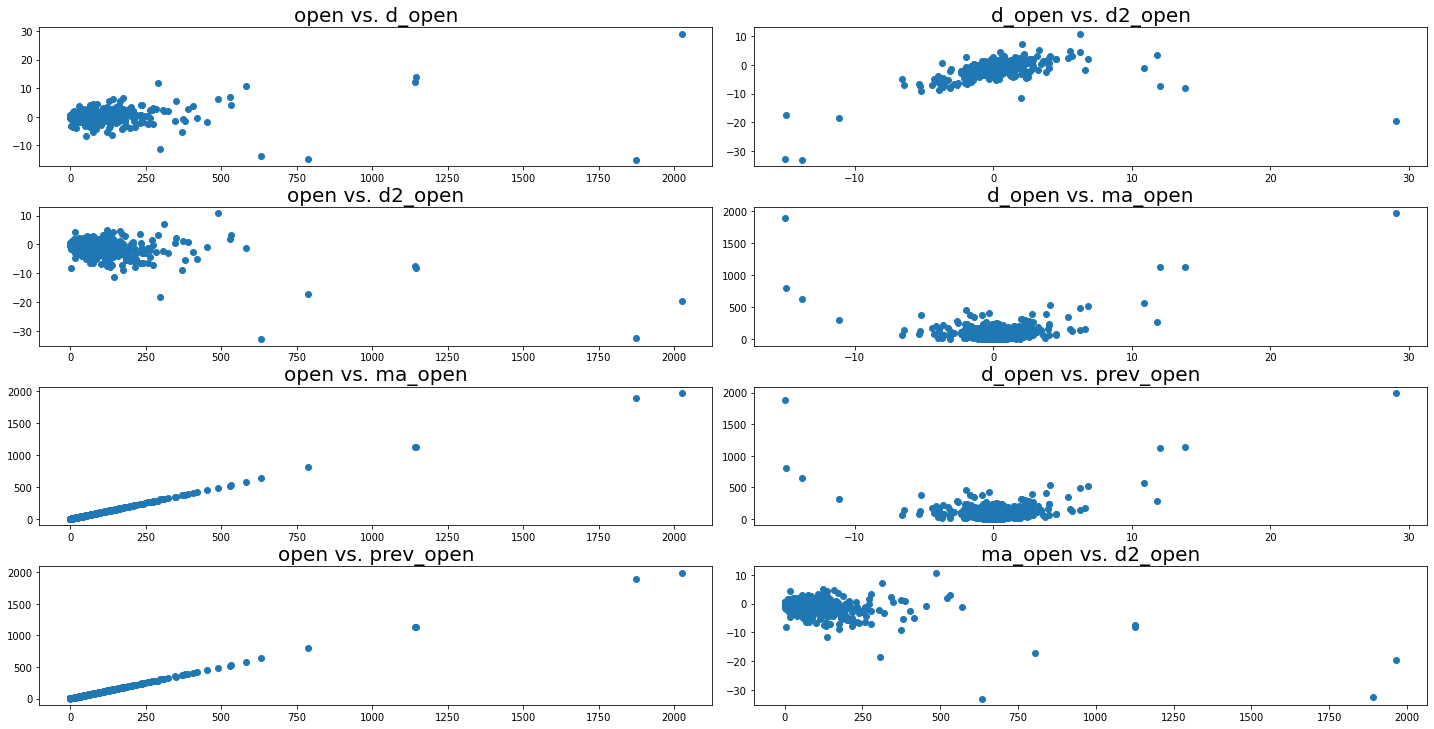

In [7]:
fig, ax = pyplot.subplots(figsize=(20, 10), nrows=4, ncols=2)
fig.tight_layout(h_pad=2)

ax[0, 0].set_title("open vs. d_open", fontsize=20);
ax[0, 0].scatter(df_07_11_2019["open"], df_07_11_2019["d_open"]);

ax[1, 0].set_title("open vs. d2_open", fontsize=20);
ax[1, 0].scatter(df_07_11_2019["open"], df_07_11_2019["d2_open"]);

ax[2, 0].set_title("open vs. ma_open", fontsize=20);
ax[2, 0].scatter(df_07_11_2019["open"], df_07_11_2019["ma_open"]);

ax[3, 0].set_title("open vs. prev_open", fontsize=20);
ax[3, 0].scatter(df_07_11_2019["open"], df_07_11_2019["prev_open"]);

ax[0, 1].set_title("d_open vs. d2_open", fontsize=20);
ax[0, 1].scatter(df_07_11_2019["d_open"], df_07_11_2019["d2_open"]);

ax[1, 1].set_title("d_open vs. ma_open", fontsize=20);
ax[1, 1].scatter(df_07_11_2019["d_open"], df_07_11_2019["ma_open"]);

ax[2, 1].set_title("d_open vs. prev_open", fontsize=20);
ax[2, 1].scatter(df_07_11_2019["d_open"], df_07_11_2019["prev_open"]);

ax[3, 1].set_title("ma_open vs. d2_open", fontsize=20);
ax[3, 1].scatter(df_07_11_2019["ma_open"], df_07_11_2019["d2_open"]);

## 2.4.3. Collect our thoughts on the visualizations

Looking at our data, there generally appears to be a single tight clustering and then a sizable set of outliers/leverage poitns which are not tightly clustered. It does not seem two people would be able to agree on how to split up these points. If you said draw two cirles/ovals (strictly speaking) to differentiate two clusters it's doubtful that any two people would agree on both the drawings. This is an example of a problem where the starting point may have an impact on our centroids.

# 3. Explore The Scikit-Learn Implimentation
The python library named "scikitlearn" has a number of machine learning algorithms in it. One of them is the K-Means algorithm. We will be using this model in the coming section. For more documentation on this implimentation see the following [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [8]:
# Import the library with our model
from sklearn.cluster import KMeans

## 3.2. The univariate case
To start things off slow, we will look at a univariate example. We will generate clusters solely based on the open price of the stock.

### 3.2.1. Training our Model
The code to train the kmeans algorithm is fairly straight forward

In [9]:
# Create a copy of our dataframe so we can play around
copy = df_07_11_2019.copy()

# Create an instance of our model
model = KMeans(n_clusters=5, random_state=42)

# Set the parameters for our model
copy["Y"] = 1 # Kmeans requires a 2D array so we will add a static column
model_parameters = copy[["open", "Y"]]
fit = model.fit(model_parameters)

There are a few objects worth discussing here:
* The *model* variable represents an instance of the KMeans class. This object holds metadata about our clustering algorithm such as the max number of iterations for our search algorithm, the number of clusters to find, etc.
* The *fit* variable represents an instance of a calibrated KMeans algorithm. Using the fit object, we can make predictions about points not contained in our training set. It also holds metadata supplied to the model which configure how the fit is obtained (eg. the max iterations) and information about the centroids and their effieicnecy.

### 3.2.2. Mapping clusters and centroids to data points

Now that we have this information, how do we know which cluster each datapoint fits into and what the coresponding centroid is? This will take a little programming magic becasue scikitlearn does not store all this information in one place. We start by getting a list of centroids

In [10]:
centroids = model.cluster_centers_
centroids[0:5]

array([[1.64302601e+01, 1.00000000e+00],
       [3.15819767e+02, 1.00000000e+00],
       [1.95053500e+03, 1.00000000e+00],
       [9.57415833e+01, 1.00000000e+00],
       [1.02527333e+03, 1.00000000e+00]])

The *centroids* variable is a pointer to a 2D array of centroids. The order of the centroids indicates their cluster identity. Ie. the first centroid is cluster 0, the third is cluster 2, the nth is cluster n. We can separate the centroids by dimension based on the order of the columns:

In [11]:
x_centroids = centroids[:, 0] # Remember, numpy is row, column... so we want a "slice" of all the rows in the first column
y_centroids = centroids[:, 1] 
x_centroids[0:4]

array([  16.43026006,  315.81976744, 1950.535     ,   95.74158329])

The other piece of information the scikitlearn model gives us is a mapping of each datapoint to a given cluster.

In [12]:
# Extract some information
copy["cluster"] = fit.labels_.astype(int)
copy["cluster"][0 : 4]

22498    3
22499    0
22500    0
22501    0
Name: cluster, dtype: int32

So now we have to map each datapoint to each centroid using the cluster index supplied. A python list comprehension makes this short work:

In [13]:
copy["centroid"] = [centroids[:, 0][i] for i in copy["cluster"]]
copy[["cluster", "centroid"]].head()

,cluster,centroid
22498,3,95.74158
22499,0,16.43026
22500,0,16.43026
22501,0,16.43026
22502,0,16.43026


### 3.2.3. Visualizing the results
Our graphing library Matplotlib has a nice functionality that allows us to color code points using a numerical value. We can supply our cluster index as this numerical value and generate nice visuals illustrating our cluster parimiters and sharacteristics.

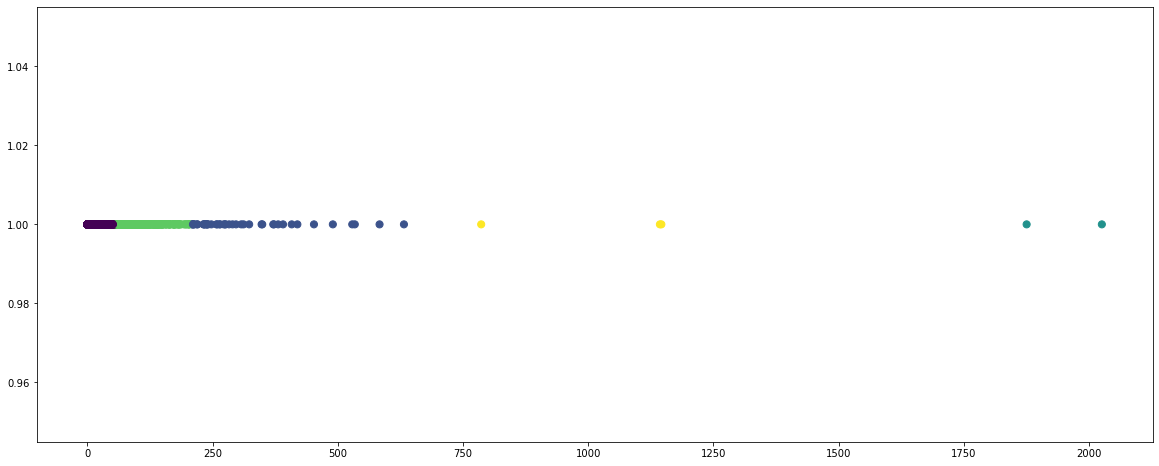

In [14]:
fig, ax = pyplot.subplots(figsize=(20, 8))
x = copy["open"]
y = [1 for i in copy["centroid"]]
colors = copy["cluster"]
pyplot.scatter(x, y, c=colors, s=50);

## 3.2. The multivariate case
Now that we have our feet wet, lets look at how k-means accomodates multiple variables simultaneously.

### 3.2.1. Removing NaNs and Infinity from training data
The first thing to note is that there is an [bug](https://github.com/scikit-learn/scikit-learn/issues/16529) prior to v0.24.1 that prevents the library from working correctly. You may come accross this issue when doing something like what we are doing in this notebook: we created a moving average which introduces NaNs to the rows occurring before the moving window was filled with points. These NaNs break the model so we need to remove them. As do Infinity. In this short section we look at identifying the problematic cells and removing them.

First we can identify the bad data:

In [15]:
# Find bad cells in a problematic dataframe
df_07_10_2019 = pandas_dataframe[pandas_dataframe["date"] == '2019-07-10']
bad_chars = [numpy.nan, numpy.inf, -numpy.inf]
# We want to identify bad data bby the row and not the column
# We can use the any() function to do this, and the axis param to specify using rows and not columns
axis = 1
bad_rows = df_07_10_2019.isin(bad_chars).any(axis)
df_07_10_2019[bad_rows].head()

,ticker,interval,date,open,high,low,close,volume,d_open,d2_open,ma_open,prev_open
19309,ADRA,D,2019-07-10,30.94000,30.94000,30.94000,30.94000,300,-0.22000,-0.09880,NaN,31.16000
19328,AFHBL,D,2019-07-10,9.35490,9.35490,8.34000,8.80000,10000,-0.24510,-0.80010,NaN,9.60000
19332,AGBAU,D,2019-07-10,10.05000,10.05000,10.05000,10.05000,5000,0.00000,-0.03000,NaN,10.05000
19367,ALAC,D,2019-07-10,10.11000,10.11000,10.11000,10.11000,100000,0.02000,0.03000,NaN,10.09000
19368,ALACW,D,2019-07-10,0.14000,0.14000,0.14000,0.14000,200,0.00000,-0.01000,NaN,0.14000


In the section above, we see that we can quickly identify the bad rows using a combination of the isin() function and the .any() function provided to the pandas DataFrame and Series respectively. We can then use these bad rows as indices and select the problematic rows.

We can also do the inverse and select only the good rows using the "~" (bitwise not) operator.

In [16]:
good_rows = ~df_07_10_2019.isin(bad_chars).any(1)
df_07_10_2019[good_rows].head()

,ticker,interval,date,open,high,low,close,volume,d_open,d2_open,ma_open,prev_open
19255,AABA,D,2019-07-10,69.99000,70.09000,69.18000,69.33000,2688100,1.09000,1.85000,69.90000,68.90000
19256,AAL,D,2019-07-10,32.93000,33.68500,32.59000,32.94000,8869700,0.53000,0.12000,32.45200,32.40000
19257,AAME,D,2019-07-10,2.34000,2.41000,2.26000,2.29000,2400,-0.10000,-0.27000,2.37000,2.44000
19258,AAOI,D,2019-07-10,10.84000,11.09500,10.18000,10.31000,1013300,0.73000,0.34000,10.12200,10.11000
19259,AAON,D,2019-07-10,50.30000,51.33000,50.18000,51.03000,127100,0.57000,0.19000,49.70200,49.73000


### 3.2.2. Applying K-Means to multiple features

In [17]:
# Create a copy of our dataframe so we can play around
copy = df_07_11_2019.copy()

# Remove any bad data
copy = copy[~copy.isin([numpy.nan, numpy.inf, -numpy.inf]).any(1)]

# Create an instance of our model
model = KMeans(n_clusters=5, random_state=42)

# Set the parameters for our model
variables = ["open", "d_open", "d2_open", "ma_open", "prev_open"]
model_parameters = copy[variables]
fit = model.fit(model_parameters)

# Set the cluster for the coresponding data point
copy["cluster"] = fit.labels_.astype(int)

# Set the centroid coresponding to that cluster
centroids = model.cluster_centers_
copy["centroids"] = [centroids[cluster] for cluster in copy["cluster"]]

copy.head()

,ticker,interval,date,open,high,low,close,volume,d_open,d2_open,ma_open,prev_open,cluster,centroids
22498,AABA,D,2019-07-11,69.38000,69.72000,68.90000,69.28000,2534300,-0.61000,-1.70000,69.59400,69.99000,4,"[92.29757898383372, 0.07322471131639785, -1.04..."
22499,AAL,D,2019-07-11,33.06000,33.30000,32.82000,33.03000,6842800,0.13000,-0.40000,32.58400,32.93000,0,"[16.207586599477416, -0.022697984322508136, -0..."
22500,AAME,D,2019-07-11,2.34500,2.34500,2.29000,2.29000,800,0.00500,0.10500,2.37500,2.34000,0,"[16.207586599477416, -0.022697984322508136, -0..."
22501,AAOI,D,2019-07-11,10.45000,10.45000,9.87000,9.90000,610700,-0.39000,-1.12000,10.20000,10.84000,0,"[16.207586599477416, -0.022697984322508136, -0..."
22502,AAON,D,2019-07-11,50.98000,51.14000,49.68000,49.85000,83600,0.68000,0.11000,49.84800,50.30000,0,"[16.207586599477416, -0.022697984322508136, -0..."


Our centroids are now expressed for multivariate vectors. 

We can extract the information into a table to show us what is what. Below, each row coresponds to a cluster. Each column coresponds to a variable. The first row is the first cluster, the first column is the first variable.

In [18]:
centroids_df = pandas.DataFrame(centroids, columns=variables)
centroids_df

,open,d_open,d2_open,ma_open,prev_open
0,16.20759,-0.02270,-0.15981,16.19666,16.23028
1,1950.53500,7.02000,-26.09500,1929.51100,1943.51500
2,927.00750,-0.71750,-16.45750,923.01550,927.72500
3,296.20404,1.01660,-2.06085,294.25596,295.18745
4,92.29758,0.07322,-1.04007,91.85052,92.22435


We can find the distance between clusters using the norm of the difference between the centroids

In [19]:
# Create an adjacency matrix
shape = (len(centroids), len(centroids))
distances = numpy.zeros(shape, dtype=int, order='C')
for row in range(0, len(distances)):
    for column in range(0, len(distances[0])):
        a = centroids[row]
        b = centroids[column]
        distance = numpy.linalg.norm(a - b)
        distances[row][column] = distance
distance = pandas.DataFrame(distances)
distance

,0,1,2,3,4
0,0,3334,1575,483,131
1,3334,0,1758,2851,3202
2,1575,1758,0,1092,1444
3,483,2851,1092,0,351
4,131,3202,1444,351,0


Lets look at the clusters visually. Each cluster has a unique color. The cluster centroids are indicated in red.

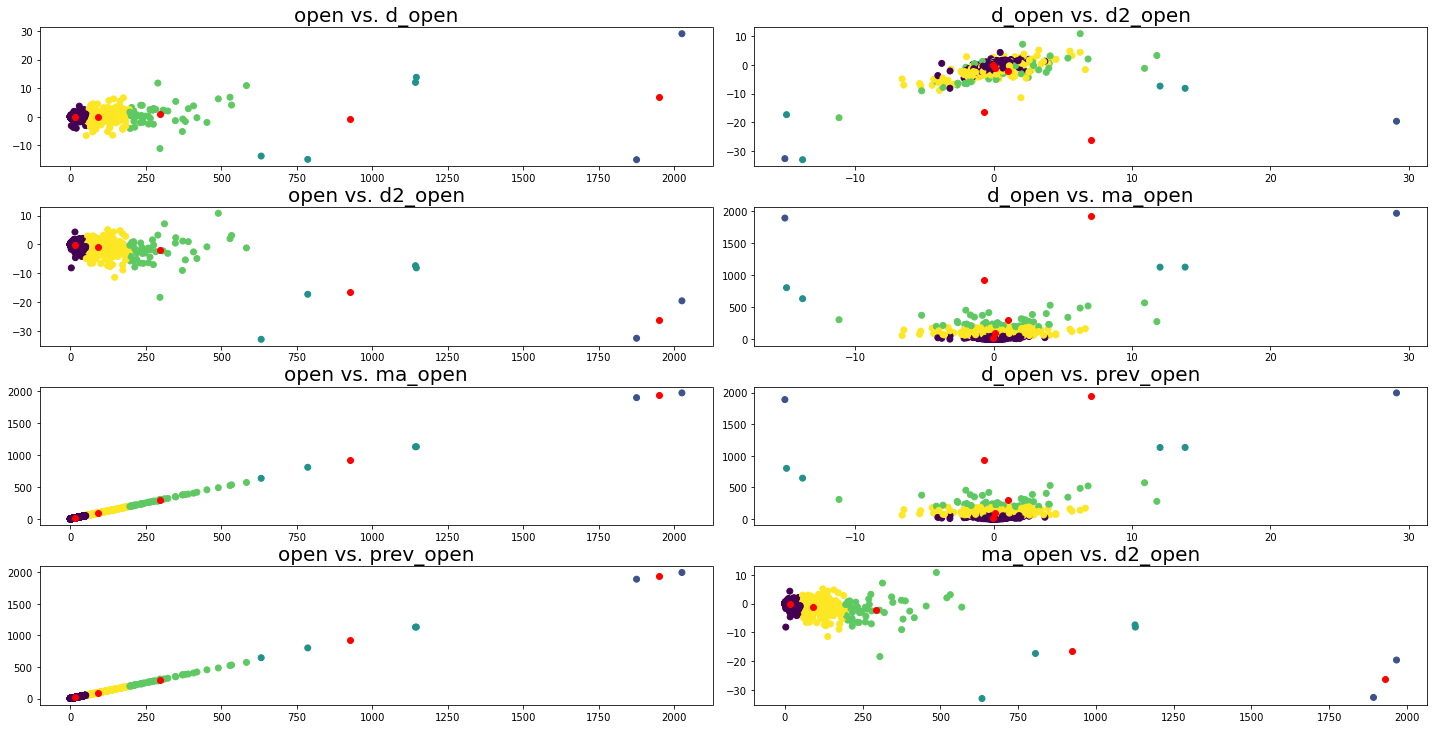

In [20]:
fig, ax = pyplot.subplots(figsize=(20, 10), nrows=4, ncols=2)
fig.tight_layout(h_pad=2)

ax[0, 0].set_title("open vs. d_open", fontsize=20);
ax[0, 0].scatter(copy["open"], copy["d_open"], c=copy["cluster"]);
ax[0, 0].scatter(centroids_df["open"], centroids_df["d_open"], c='red')

ax[1, 0].set_title("open vs. d2_open", fontsize=20);
ax[1, 0].scatter(copy["open"], copy["d2_open"], c=copy["cluster"]);
ax[1, 0].scatter(centroids_df["open"], centroids_df["d2_open"], c='red')

ax[2, 0].set_title("open vs. ma_open", fontsize=20);
ax[2, 0].scatter(copy["open"], copy["ma_open"], c=copy["cluster"]);
ax[2, 0].scatter(centroids_df["open"], centroids_df["ma_open"], c='red')

ax[3, 0].set_title("open vs. prev_open", fontsize=20);
ax[3, 0].scatter(copy["open"], copy["prev_open"], c=copy["cluster"]);
ax[3, 0].scatter(centroids_df["open"], centroids_df["prev_open"], c='red')

ax[0, 1].set_title("d_open vs. d2_open", fontsize=20);
ax[0, 1].scatter(copy["d_open"], copy["d2_open"], c=copy["cluster"]);
ax[0, 1].scatter(centroids_df["d_open"], centroids_df["d2_open"], c='red')

ax[1, 1].set_title("d_open vs. ma_open", fontsize=20);
ax[1, 1].scatter(copy["d_open"], copy["ma_open"], c=copy["cluster"]);
ax[1, 1].scatter(centroids_df["d_open"], centroids_df["ma_open"], c='red')

ax[2, 1].set_title("d_open vs. prev_open", fontsize=20);
ax[2, 1].scatter(copy["d_open"], copy["prev_open"], c=copy["cluster"]);
ax[2, 1].scatter(centroids_df["d_open"], centroids_df["prev_open"], c='red')

ax[3, 1].set_title("ma_open vs. d2_open", fontsize=20);
ax[3, 1].scatter(copy["ma_open"], copy["d2_open"], c=copy["cluster"]);
ax[3, 1].scatter(centroids_df["ma_open"], centroids_df["d2_open"], c='red');

# 4. Colors and Matplotlib Scatter Plots
Previously we have been using the cluster index to represent the color for a given point. Behind the scenes there is some magic happening to map those cluster numbers to colors. In this section we have a look at how this works. We also look at pulling human names for the associated colors.

In a nutshell, we are answeing the question "Hey, which cluster in that purple cluster?"

In [21]:
# Import the color map and webcolor libraries to help us identify the colors assigned in our visualization

import matplotlib.cm as cm
import webcolors

# When we used pyplot earlier to create a scatter plot, we used the cluster indexes as a color code
# Behind the scenes, pyplot uses the viridis color map (by default) to convert numbers into colors.
# It does this by normalizing the integer values according to the cluster index range and then
# looking up the coresponding hexadecimal color value for the coresponding normalized value 
# We needed to do some magic to reverse engineer the process

def int_to_hex(value, cmap_name='viridis', vmin=0, vmax=1):
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)
    rgb = cmap(norm(abs(value)))[:3]
    color = matplotlib.colors.rgb2hex(rgb)
    return color

# Mapping the hexedecimal number to the human friendly name is a tricky subject.
# For a small craction of colors, theres is a CSS standard which dictates a name for the code
# For all the rest... there is no standard
# I have seen implimentations where a site (like xkcd) takes a survey of the color names and provides a lookup table
# I have taken a hybrid approach:
# We have the CSS lookups and we have some exact matches in a lookup table
# I use a function to find the closest value mathematically

file_path = "rgb.txt"
color_dataframe = pandas.read_csv(file_path, names=["name", "hex"], header=None, comment='!', skip_blank_lines=True)
color_dataframe.head()
    
def closest_colour(rgb_tuple):

    min_colours = {}
    for i, row in color_dataframe.iterrows():
        color_name = row["name"]
        color_hex = row["hex"]
        r_c, g_c, b_c = webcolors.hex_to_rgb(color_hex)
        rd = (r_c - rgb_tuple[0]) ** 2
        gd = (g_c - rgb_tuple[1]) ** 2
        bd = (b_c - rgb_tuple[2]) ** 2
        min_colours[(rd + gd + bd)] = color_name
    return min_colours[min(min_colours.keys())]

In [22]:
# Get paramters for the color conversion
vmin = copy['cluster'].min()
vmax = copy['cluster'].max()
color_df = pandas.DataFrame({}, columns=["cluster", "color hex", "rgb", "color name"])
cluster_numbers = numpy.sort(copy["cluster"].unique())
for cluster_number in cluster_numbers:    
    color_hex = int_to_hex(cluster_number, vmin=vmin, vmax=vmax)
    color_rgb = tuple(webcolors.hex_to_rgb(color_hex))
    color_name = closest_colour(color_rgb)
    color_df = color_df.append({
        "cluster": cluster_number, 
        "color hex": color_hex, 
        "rgb": color_rgb, 
        "color name": color_name
    }, ignore_index=True)
color_df.head()

,cluster,color hex,rgb,color name
0,0,#440154,"(68, 1, 84)",dark purple
1,1,#3b528b,"(59, 82, 139)",dark slate blue
2,2,#21918c,"(33, 145, 140)",dark cyan
3,3,#5ec962,"(94, 201, 98)",bright green
4,4,#fde725,"(253, 231, 37)",gold


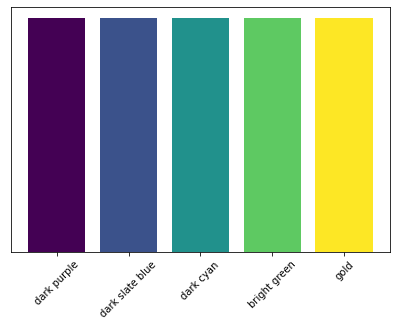

In [23]:
fig, ax = pyplot.subplots()
fig.tight_layout(h_pad=2)
ax.get_yaxis().set_visible(False)
ax.tick_params(axis='x', labelrotation=45) 
ax.bar(color_df["color name"], [5 for x in color_df["cluster"]], color=color_df["color hex"]);

# 5. Hyperparameter Tuning the K-Means Algorithm
The K-Means algorithm has only one parameter which makes it a great model to talk about if you're new to hyperparameter tuning. Having one parameter to optimize means simpler code and simpler processes to check our work.

## 5.1. Hyperparameter tuning refresher
In a nutshell, hyperparameter tuning is an exercise of optimizing a loss function. Another way of saying this is finding the optimal parameter which yields the best fit given computational constraints.

No matter what model or parameter set the problem breaks down to a **loss function** and an **optimization technique**; the former typically informing the latter. The loss function measures how well our model fit the data or performed during testing. The optimization technique is the method by which we determine our optimal parameter set.

## 6.2. The Loss Function for K-Means Optimization
As mentioned earlier, we can break this problem down into two simple components: a loss function and an optimization technique. 

For our loss function, we can use sum of squares which is provided out-of-the-box by scikit-learn. Note: There are many possible loss functions that one can use, we have selected this function out of convenience.

### 6.2.1. Sum Of Squares

Recall the following definition:

$$ Sum \ of \ squares  = \sum^n_{i=0}(x_i - \bar{x})^2 $$

In this case, $X$ represents the values of the variables associated with the cluster at a given point in time.

### 6.2.1. Sum Of Squares using scikitlearn

The K-Means implimentation from scikitlearn already builds this calculatation into the model object it creates. We will modify our code from before to take advantage of this feature.

In [24]:
# Create a copy of our dataframe so we can play around
copy = df_07_11_2019.copy()

# Remove any bad data
copy = copy[~copy.isin([numpy.nan, numpy.inf, -numpy.inf]).any(1)]

# Specify a maximum number of clusters to try
max_cluster_count = 30
range_of_cluster_counts = range(1, max_cluster_count)

# Create a progress bar to keep us updates while the numbers crunch
num_ops = max_cluster_count
bar = progressbar.ProgressBar(maxval=num_ops, widgets=progress_bar_widgets)
bar.start()
count = 0

# Fit the data using the number of clusters specified
cluster_sos = None
for cluster_count in range_of_cluster_counts:
    
    # Create an instance of our model
    model = KMeans(n_clusters=cluster_count, random_state=42)

    # Set the parameters for our model
    model_parameters = copy[["open", "d_open", "d2_open", "ma_open", "prev_open"]]
    fit = model.fit(model_parameters)

    # Save the sos data
    row = {
        "cluster count": cluster_count,
        "sos": model.inertia_
    }
    if cluster_sos is None:
        cluster_sos = pandas.DataFrame(row, index=[0])
    else:
        cluster_sos = cluster_sos.append(row, ignore_index=True)
    
    # Update the progress bar
    count += 1
    bar.update(count)

bar.finish()

[=====================================] Processed: 30 / 3530 ops Time:  0:00:07


In [25]:
cluster_sos.head(10)

,cluster count,sos
0,1.00000,52940926.55852
1,2.00000,25288408.42660
2,3.00000,12238345.98847
3,4.00000,7384636.27569
4,5.00000,5021840.46284
5,6.00000,3030011.07666
6,7.00000,2110835.33600
7,8.00000,1487709.16141
8,9.00000,1120049.65002
9,10.00000,865522.18517


We can plot our SOS accross the values of our hyper parameter and assess what number of clusters is best.

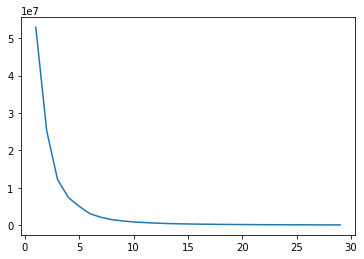

In [26]:
pyplot.plot(cluster_sos["cluster count"], cluster_sos["sos"]);

Visually we might assess that somewhere between 5 and 10 is the point where marginal benefit becomes insignificant. But how do we mathematically choose an exact point? There are a number of methods. A large branch of them full under the category of the "elbow method". This is discussed in greater detail in the Optimization notebook.

Luckily, there is a python implimentation of this method available in the [kneed library](https://github.com/arvkevi/kneed).

Our knee point is: 6


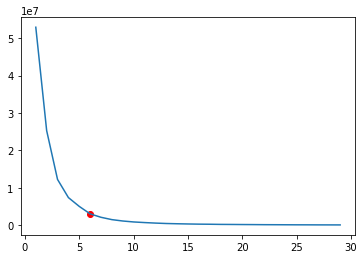

In [27]:
import kneed
x = cluster_sos["cluster count"]
y = cluster_sos["sos"]
kneedle = kneed.KneeLocator(x, y, S=1.0, curve="convex", direction="decreasing")
knee_point = int(kneedle.knee)
print("Our knee point is: {0}".format(knee_point))
fig, ax = pyplot.subplots()
ax.plot(cluster_sos["cluster count"], cluster_sos["sos"]);
ax.scatter(knee_point, cluster_sos[cluster_sos["cluster count"] == knee_point]["sos"], c='red');

So we can apply this optimization technique to K-Means and select the best number of clusters dynamically

In [28]:
from sklearn.cluster import KMeans

def fit_kmeans_to_data(x, y, num_clusters, random_state=42):
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=random_state)
    df = pandas.DataFrame({
        "x": x,
        "y": y
    })
    fit = kmeans.fit(df)
    centroids = kmeans.cluster_centers_
    return fit, centroids, kmeans

In [38]:
def perform_kmeans_for_date(df, date, random_state):

    # Get a subset of our data for a particular date
    date_df = df[df["date"] == date]

    # Set the parameters for our model
    variables = ["open", "d_open", "d2_open", "ma_open", "prev_open"]    
    
    # Remove any bad data
    date_df = date_df[~date_df[variables].isin([numpy.nan, numpy.inf, -numpy.inf]).any(1)]

    # Fit the model to find a varying number of clusters
    cluster_counts = list(range(1, 31))
    model_data = {}
    for num_clusters in cluster_counts:
    
        # Create an instance of our model
        model = KMeans(n_clusters=num_clusters, random_state=random_state)

        # Fit the model
        model_parameters = date_df[variables]
        fit = model.fit(model_parameters)
        
        # Store information         
        model_data[num_clusters] = {
            "sos": model.inertia_,
            "fit": fit,
            "centroids": model.cluster_centers_,
            "model": model,            
        }

    # Determine the knee point and thus the optimal hyper parameters
    import kneed
    knee_x = cluster_counts
    knee_y = [model_data[cluster_count]["sos"] for cluster_count in cluster_counts]
    kneedle = kneed.KneeLocator(knee_x, knee_y, S=1.0, curve="convex", direction="decreasing")
    knee = int(kneedle.knee)  
    
    # Retrieve information
    fit = model_data[knee]["fit"]
    centroids = model_data[knee]["centroids"]
    model = model_data[knee]["model"]    
        
    # Set the clusters and centroids
    date_df["cluster"] = fit.labels_.astype(int)
    date_df["centroid"] = [centroids[:, 0][i] for i in date_df["cluster"]]
    print(date_df.columns)
    
    # Add the information back to the dataframe
    df.update(date_df)
    print(df.columns)
    
    return date_df

# Sanity check the code is working
df_07_12_2019 = perform_kmeans_for_date(pandas_dataframe, '2019-07-12', 42)

Index(['ticker', 'interval', 'date', 'open', 'high', 'low', 'close', 'volume',
       'd_open', 'd2_open', 'ma_open', 'prev_open', 'cluster', 'centroid'],
      dtype='object')
Index(['ticker', 'interval', 'date', 'open', 'high', 'low', 'close', 'volume',
       'd_open', 'd2_open', 'ma_open', 'prev_open'],
      dtype='object')


Index(['ticker', 'interval', 'date', 'open', 'high', 'low', 'close', 'volume',
       'd_open', 'd2_open', 'ma_open', 'prev_open'],
      dtype='object')

In [34]:
df_07_11_2019.head()

,ticker,interval,date,open,high,low,close,volume,d_open,d2_open,ma_open,prev_open
22498,AABA,D,2019-07-11,69.38000,69.72000,68.90000,69.28000,2534300,-0.61000,-1.70000,69.59400,69.99000
22499,AAL,D,2019-07-11,33.06000,33.30000,32.82000,33.03000,6842800,0.13000,-0.40000,32.58400,32.93000
22500,AAME,D,2019-07-11,2.34500,2.34500,2.29000,2.29000,800,0.00500,0.10500,2.37500,2.34000
22501,AAOI,D,2019-07-11,10.45000,10.45000,9.87000,9.90000,610700,-0.39000,-1.12000,10.20000,10.84000
22502,AAON,D,2019-07-11,50.98000,51.14000,49.68000,49.85000,83600,0.68000,0.11000,49.84800,50.30000


KeyError: 'cluster'

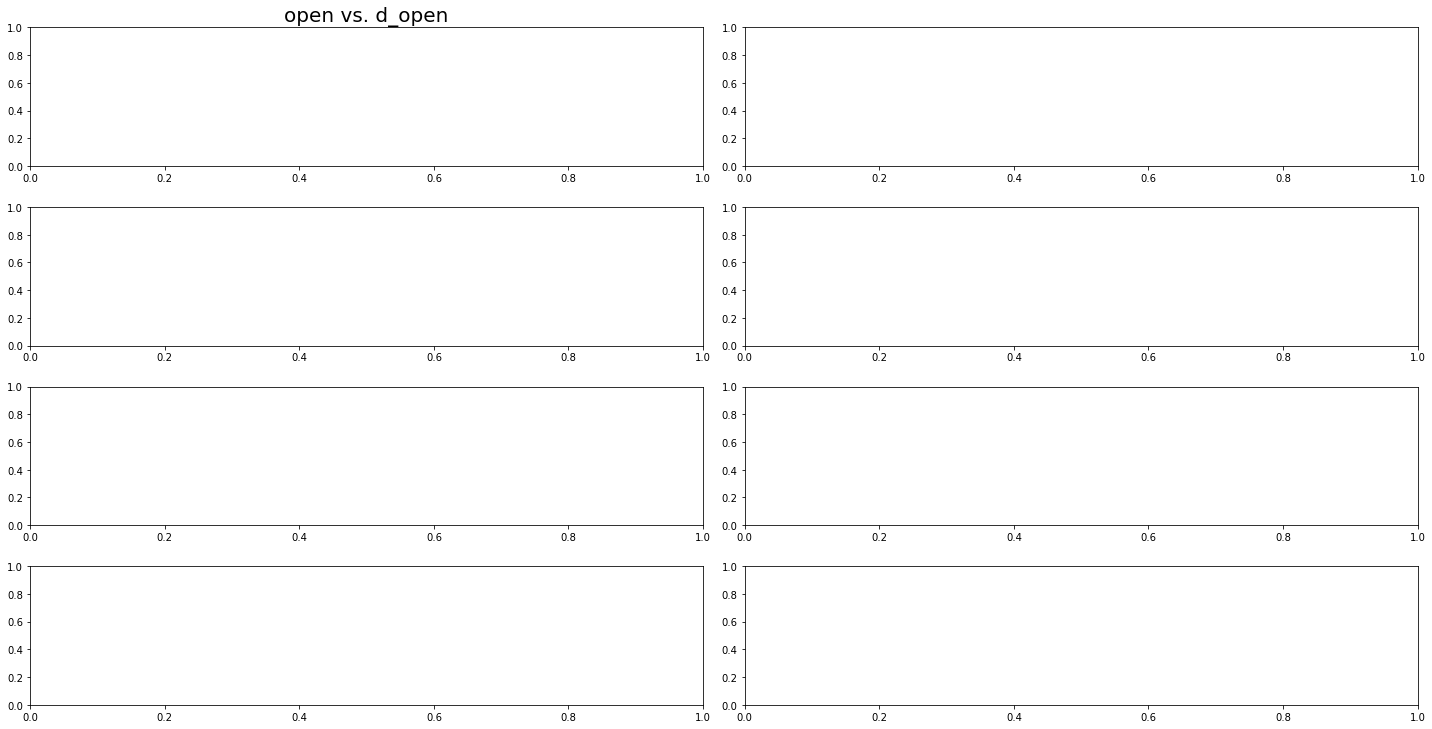

In [32]:
fig, ax = pyplot.subplots(figsize=(20, 10), nrows=4, ncols=2)
fig.tight_layout(h_pad=2)

ax[0, 0].set_title("open vs. d_open", fontsize=20);
ax[0, 0].scatter(df_07_11_2019["open"], df_07_11_2019["d_open"], c=df_07_11_2019["cluster"]);

ax[1, 0].set_title("open vs. d2_open", fontsize=20);
ax[1, 0].scatter(df_07_11_2019["open"], df_07_11_2019["d2_open"], c=df_07_11_2019["cluster"]);

ax[2, 0].set_title("open vs. ma_open", fontsize=20);
ax[2, 0].scatter(df_07_11_2019["open"], df_07_11_2019["ma_open"], c=df_07_11_2019["cluster"]);

ax[3, 0].set_title("open vs. prev_open", fontsize=20);
ax[3, 0].scatter(df_07_11_2019["open"], df_07_11_2019["prev_open"], c=df_07_11_2019["cluster"]);

ax[0, 1].set_title("d_open vs. d2_open", fontsize=20);
ax[0, 1].scatter(df_07_11_2019["d_open"], df_07_11_2019["d2_open"], c=df_07_11_2019["cluster"]);

ax[1, 1].set_title("d_open vs. ma_open", fontsize=20);
ax[1, 1].scatter(df_07_11_2019["d_open"], df_07_11_2019["ma_open"], c=df_07_11_2019["cluster"]);

ax[2, 1].set_title("d_open vs. prev_open", fontsize=20);
ax[2, 1].scatter(df_07_11_2019["d_open"], df_07_11_2019["prev_open"], c=df_07_11_2019["cluster"]);

ax[3, 1].set_title("ma_open vs. d2_open", fontsize=20);
ax[3, 1].scatter(df_07_11_2019["ma_open"], df_07_11_2019["d2_open"], c=df_07_11_2019["cluster"]);

For more information about the application of K-Means, check out the notebooks regarding cluster analysis of time series data.